**DeepXDE for Thin Film Flow**

Theodoret Putra Agatho on 25 Sept. 2023

[Case Reference](https://doi.org/10.22342/jims.29.1.1110.99-105)

In [1]:
pip install deepxde

**Problem setup**

The thickness on film flow fluid can be described with following equation:

\begin{align}
        \frac{\partial \eta}{\partial t} + a \frac{\partial \eta}{\partial x} + b \frac{\partial ^2 \eta}{\partial x^2} = 0, x \in [0,100], t \in [0,120]
    \end{align}

the Dirichlet boundary conditions and initial conditions are as follows:

\begin{align}
        \eta (0,t) = \eta (100,t) = 0
    \end{align}

\begin{align}
    \eta (x, 0) = \sin (0.1 \pi (x - 10)) \text{ for } x \in [10, 20]
    \end{align}

and $a$ and $b$ values are as follows:

\begin{align}
    a = \sin (\theta), b = -\frac{1}{3} \delta \cos (\theta)
    \end{align}

where,

\begin{align}
    \theta = 15°, \delta = 1
    \end{align}

**Implementation**

This description goes through the implementation of a solver for the above described equation step-by-step.

First, the DeepXDE, numpy, and TensorFlow (`tf`) modules are imported:

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


and the constant parameters are declared.

In [3]:
theta = np.deg2rad(15)
delta = 1

a = np.sin(theta)
b = -delta/3 * np.cos(theta)

First, a computational geometry and time domain are defined. A built-in class `Interval` and `TimeDomain` can be used and the domains are combined using `GeometryXTime` as follows:

In [4]:
geom = dde.geometry.Interval(0, 100)
timedomain = dde.geometry.TimeDomain(0, 120)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, the PDE residual of the equation is expressed as follows:

In [5]:
def pde(x, y):
  dy_x = dde.grad.jacobian(y, x, i=0, j=0)
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t + a * dy_x + b * dy_xx

The first argument to `pde` is 2-dimensional vector where the first component (`x[:,0]`) is $x$-coordinate and the the second componenet (`x[:,1]`) is the $t$-coordinate. The second argument is the network output, *i.e.*, the solution $T(x,t)$, but `y` is used here as the name of the variable.

Next, the boundary/initial conditions are considered. `on_boundary` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. The `geomtime` space is included, time geometry created above and `on_boundary` as the BCs in the `DirichletBC` function of DeepXDE. `IC` is also defined which is the initial conditon for the equation and the computational domain, initial function, and `on_initial` are used to specify the IC.

In [6]:
def initial_condition(x, on_initial):
  return on_initial and (np.greater(x[0], 20) or np.less(x[0], 10))

def initial_condition_on_curve(x, on_initial):
  return np.less_equal(x[0], 20) and np.greater_equal(x[0], 10) and on_initial

In [7]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic1 = dde.icbc.IC(geomtime, lambda x: 0, initial_condition)
ic2 = dde.icbc.IC(geomtime, lambda x: tf.sin(0.1 * np.pi * (x[:, 0:1] - 10)), initial_condition_on_curve)

Now, the geometry, PDE residual, and boundary/initial condition have been specified. Then, the `TimePDE` problem is defined as follows:

In [8]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic1, ic2],
                        num_domain=2540, num_boundary=80, num_initial=160)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. 160 initial residual points are also included for the initial conditions.

Next, the network are chose. Here, a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20 is used.

In [9]:
net = dde.nn.FNN([2] + [32] * 3 + [1], "tanh", "Glorot normal")

Now, the PDE problem and the network are owned. Then, a `Model` is built and the optimizer and learning rate are chose.

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.333183 s

'compile' took 1.895138 s



Then the model is trained for 15000 iterations:

In [11]:
losshistory, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.43e-04, 9.07e-01, 4.12e-01, 1.60e+00]    [9.43e-04, 9.07e-01, 4.12e-01, 1.60e+00]    []  
1000      [1.45e-04, 2.98e-05, 8.85e-04, 1.60e-03]    [1.45e-04, 2.98e-05, 8.85e-04, 1.60e-03]    []  
2000      [4.82e-05, 6.97e-06, 3.19e-04, 5.47e-04]    [4.82e-05, 6.97e-06, 3.19e-04, 5.47e-04]    []  
3000      [3.44e-05, 5.48e-06, 1.56e-04, 2.71e-04]    [3.44e-05, 5.48e-06, 1.56e-04, 2.71e-04]    []  
4000      [2.63e-05, 4.50e-06, 1.11e-04, 2.31e-04]    [2.63e-05, 4.50e-06, 1.11e-04, 2.31e-04]    []  
5000      [1.95e-05, 3.86e-06, 7.84e-05, 1.75e-04]    [1.95e-05, 3.86e-06, 7.84e-05, 1.75e-04]    []  
6000      [1.76e-05, 3.83e-06, 4.57e-05, 9.26e-05]    [1.76e-05, 3.83e-06, 4.57e-05, 9.26e-05]    []  
7000      [1.78e-05, 4.18e-06, 3.19e-05, 4.92e-05]    [1.78e-05, 4.18e-06, 3.19e-05, 4.92e-05]    []  
8000      [1.63e-05, 4.13e-06, 2.63e-05, 4.16e-

After the network is trained using Adam, the network training is continued using L-BFGS to achieve a smaller loss:

In [12]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.344642 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
15000     [1.18e-05, 4.75e-07, 8.32e-06, 8.73e-06]    [1.18e-05, 4.75e-07, 8.32e-06, 8.73e-06]    []  
16000     [8.15e-06, 1.42e-07, 3.01e-06, 1.70e-06]    [8.15e-06, 1.42e-07, 3.01e-06, 1.70e-06]        
17000     [5.96e-06, 2.30e-07, 1.59e-06, 6.90e-07]    [5.96e-06, 2.30e-07, 1.59e-06, 6.90e-07]        
18000     [4.88e-06, 4.56e-08, 7.21e-07, 3.03e-07]    [4.88e-06, 4.56e-08, 7.21e-07, 3.03e-07]        
19000     [3.89e-06, 3.64e-08, 4.88e-07, 2.33e-07]    [3.89e-06, 3.64e-08, 4.88e-07, 2.33e-07]        
20000     [2.15e-06, 4.40e-08, 3.86e-07, 1.85e-07]    [2.15e-06, 4.40e-08, 3.86e-07, 1.85e-07]        
21000     [1.20e-06, 2.79e-08, 1.64e-07, 1.69e-07]    [1.20e-06, 2.79e-08, 1.64e-07, 1.69e-07]        
22000     [7.39e-07, 1.36e-08, 9.33e-08, 6.56e-08]    [7.39e-07, 1.36e-08, 9.33e-08, 6.56e-08]        
2

Following are the loss history, where train loss is not included, and the prediction results over the trained domain.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


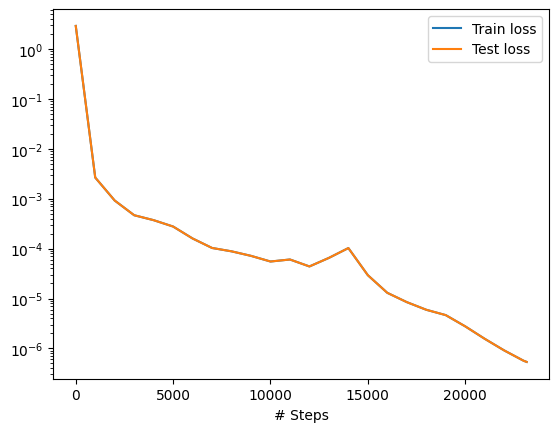

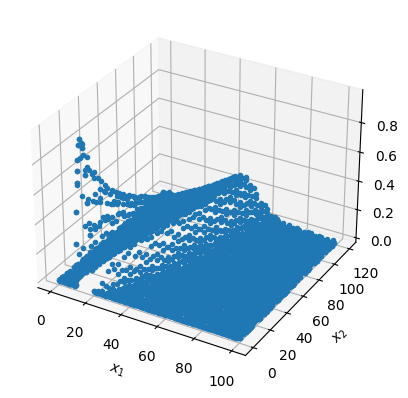

In [13]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

**Results Comparison**

The model is used now to yield a result on the certain domain and the result is compared to the Crank-Nicolson Method result.

First, functions for the method are defined and called.

In [14]:
def eq_appro_solution(x, t):
    """Returns the approximation solution for a given x and t.

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    dt = t[1] - t[0]
    t_max = t[-1]
    epoch = np.floor(t_max/dt)+1

    Nx = x.size
    dx = x[1] - x[0]

    # Initialization
    U = np.zeros([1,Nx])
    for i in range(Nx):
      if x[i] >= 10 and x[i] <= 20:
        U[0][i] = np.sin(0.1*np.pi*(x[i] - 10))

    epoch = epoch[0].astype(int)
    history = np.zeros([Nx, epoch])

    # Crank-Nicolson Method
    sa = dt*a/(2*dx)/2
    sb = dt*b/np.power(dx,2)/2

    A = np.eye(Nx)
    A1 = np.eye(Nx); A2 = np.eye(Nx);
    for i in range(1,Nx-1):
      for j in range(1,Nx-1):
        if A[i][j] == 1:
          A1[i][j] = -1 - 2*sb
          A1[i][j-1] = -sa + sb
          A1[i][j+1] = sa + sb

          A2[i][j] = -1 + 2*sb
          A2[i][j-1] = sa - sb
          A2[i][j+1] = -sa - sb

    U = np.transpose(U)
    for i in range(epoch):
      U = np.matmul(np.matmul(np.linalg.inv(A2),A1),U)
      history[:,i] = np.squeeze(np.transpose(U))
    return history


def gen_appro_solution():
    """Generates approximation result for the equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (101, 12000)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (100, 120.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    # usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the approximation solution for each generated point:
    usol = eq_appro_solution(x, t)

    # Save solution:
    np.savez("eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the approximation result."""
    # Load the data:
    data = np.load("eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, appro = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = appro.flatten()[:, None]
    return X, y

In [15]:
gen_appro_solution()

The model prediction and the method result are fetched, then compared and saved.

In [16]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.00032691972
L2 relative error 0.04783435094020841


**Results Visualisation**



In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [18]:
x_dim, t_dim = (101, 12000)

# Bounds of 'x' and 't':
x_min, t_min = (0, 0.0)
x_max, t_max = (100, 120.0)

dt = (t_max - t_min)/t_dim
dx = (x_max - x_min)/x_dim

u_true = y_true.reshape(t_dim,x_dim)
u_pred = y_pred.reshape(t_dim,x_dim)

Crank-Nicolson Method's result

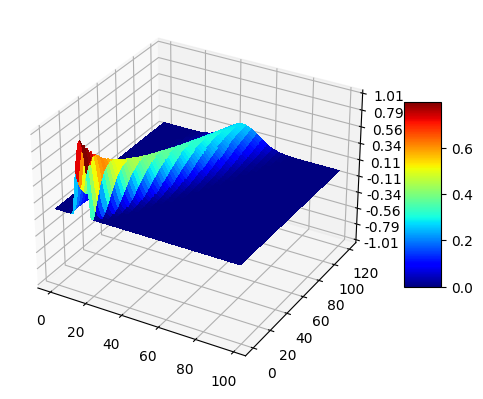

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(x_min, x_max, dx)
Y = np.arange(t_min, t_max, dt)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, u_true, cmap=cm.jet,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

DeepXDE's model results

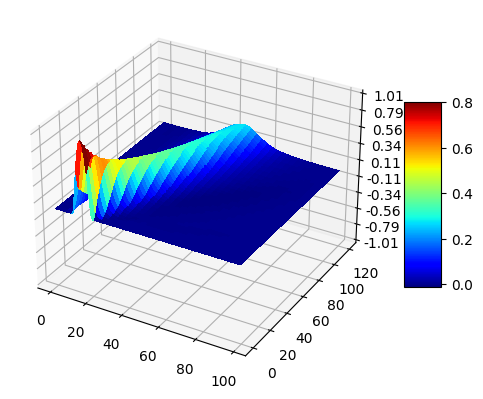

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, u_pred, cmap=cm.jet,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()